#Introduction to Recurent Neural Networks

Welcome to the RNN tutorial! We will introduce some basic concepts and implement them using Keras.

Recurrent Neural Nets are most useful for working with sequences, most notably in natural language processing. In this tutorial, we will use RNNs in their most basic setting, to do with predicting how mathematical time series may be continued.

Here is an illustration of a basic RNN, taken from a [paper](https://www.researchgate.net/publication/318332317_Audio_visual_speech_recognition_with_multimodal_recurrent_neural_networks) on speech recognition.

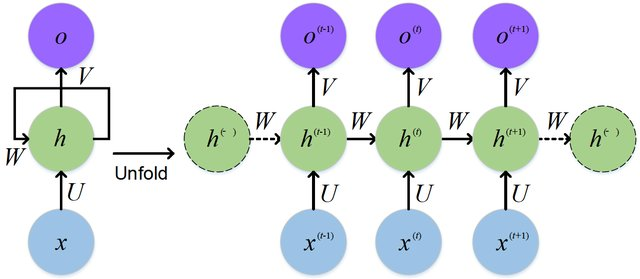

This neural network is fed a sequence of inputs $x^{(t)}$ rather than a single input. Here $U$, $V$ and $W$ are weight matrices. The "hidden states" $h^{(t)}$ are computed from inputs and previous hidden states as $h^{(t)}_i = f(U_{i j} x^{(t)}_j + W_{i j} h^{(t-1)}_j + b_i)$, for some bias $b_i$ and activation function $f$. The sequence of intermediate outputs $o_i^{(t)}$ are then found as $o^{(t)} = g(V_{i j} h^{(t)}_j + v_i)$, for some bias $b_i$.

Note that, while this is a simple generic scheme of a RNN, some examples considered may be even simpler - for example, the SimpleRNN module in Keras identifies the $h^{(t)}$ and $o^{(t)}$ layers - the output state is the same as the hidden state.

You may notice a key feature of an RNN: weights are shared across the neural network. There are several reasons to motivate this:

*   Allowing for weights to be different across the sequence would not allow us to generalize the model to sequences of varying length. 
*   Allowing the weights to vary across the sequence could make the model too flexible, and lead to overfitting. For many examples, it is helpful to assume that the sequence is governed by the same kind of rule at different places in the sequence. You may think of this as our "empirical prior", the knowledge about the system that goes into its design.



The rest of this notebook will be dealing with some simple examples of the application of RNNs. Let me just note that this content is inspired by (and some of it closely follows) Aurelien Geron's wonderful [notebooks](https://github.com/ageron/handson-ml) on deep learning, in particular #14. This is a great place to learn more about recurrent neural networks in general, and about different methods for time series forecasting in particular. This MIT [lecture](https://www.youtube.com/watch?v=SEnXr6v2ifU&t=1782s) on RNNs is very good, too.


# The Simplest RNN

Let us first generate some time series to play with. We'll start with a simple sine wave, and generate a dataset of waves shifted by some random phase.

In [83]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

def make_sine_series(len = 10,freq = 1.0, amp = 1.0, phase = 0):
  # returns a sine time series, split into its last element (to be predicted) and the rest
  times = np.linspace(0,1,len+1)
  seq = amp*np.sin(freq*times)
  return seq[:-1], seq[-1]

def make_sine_dataset(num_examples = 100,seq_len = 10,freq = 100):
  # returns a dataset of sine waves shifted by some random phase
  x_set = np.zeros((num_examples,seq_len),dtype = float)
  y_set = np.zeros((num_examples,),dtype=float)
  phase = np.pi*random.random()

  for i in range(num_examples):
    x_set[i,:], y_set[i] = make_sine_series(len = seq_len, phase = phase, freq = freq)
  x_set = x_set.reshape(num_examples,seq_len,1)
  y_set = y_set.reshape(num_examples,1)

  return x_set,y_set   

In [85]:
num_examples = 5000
seq_len = 100

x_set,y_set = make_sine_dataset(num_examples = num_examples,seq_len = seq_len,freq = 10)

# leave the last 1000 examples for validation set and put the rest in training set
x_train = x_set[:-1000,:,:]
y_train = y_set[:-1000,:]
x_valid = x_set[-1000:,:,:]
y_valid = y_set[-1000:,:]

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(4000, 100, 1)
(1000, 100, 1)
(4000, 1)
(1000, 1)


We will try to predict the next value in the series using the following neural network, using Keras' [SimpleRNN layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). Note that this simple layer does not have separate hidden state and output neurons. The goal is to predict the next element in a sequence.

In [86]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(1,input_shape=[None,1]),
    tf.keras.layers.Dense(1,activation = "tanh")
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


As you can see, this model has only 5 parameters! Looking back at our schematic, the recursive layer has 2 weights and one bias, and the Dense layer has 1 weight and 1 bias.

Let's train the model.

In [87]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
history = model.fit(x_train, y_train, epochs=5,
                    validation_data=(x_valid, y_valid))

Epoch 1/5
125/125 [==============================] - 5s 40ms/step - loss: 0.0832 - val_loss: 5.3513e-07
Epoch 2/5
125/125 [==============================] - 5s 42ms/step - loss: 3.6551e-08 - val_loss: 1.1511e-12
Epoch 3/5
125/125 [==============================] - 5s 40ms/step - loss: 9.6946e-14 - val_loss: 0.0000e+00
Epoch 4/5
125/125 [==============================] - 5s 41ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/5
125/125 [==============================] - 5s 42ms/step - loss: 0.0000e+00 - val_loss: 0.0000e+00


As we can see, this model is able to fit the data perfectly - the validation loss is zero. This is not too unexpected, since we are dealing with a completely clean dataset and are only fitting a simple sine function.

We can visualize the prediction for a particular sine curve.

---



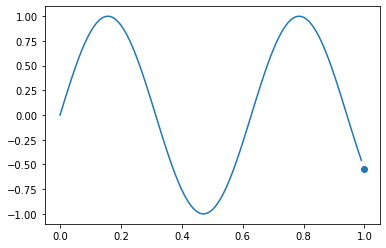

In [89]:
res = model.predict(x_train[-1:,:,:])[0]

plt.figure()
plt.plot(np.linspace(0,1-1/seq_len,seq_len),x_train[-1,:,:].reshape(-1))
plt.scatter(np.array([1]),np.array(res),marker = 'o')
plt.show()

Now let's look at some slightly more challenging examples.

# Slightly Less Simple RNN

In this section we will consider a superposition of two sine waves, and consider fitting it using a RNN with more flexibility.

In [93]:
def make_time_series(len = 10,freq1 = 1, freq2 = 0.8,amp1 = 0.4, amp2 = 0.4,phase1 = 0,phase2 = 0,noise_strength = 0.1):
  # returns a series of first L-1 elements, and a series of last L-1 elements
  times = np.linspace(0,1,len+1)
  noise = noise_strength*np.random.rand(len+1)
  seq = amp1*np.sin(freq1*times + phase1) + amp2*np.sin(freq2*times + phase2) + noise
  return seq[:-1], seq[1:]

def make_dataset(num_examples = 100,seq_len = 10,noise_strength = 0.1,freq1 = 100,freq2 = 110):
  x_set = np.zeros((num_examples,seq_len),dtype = float)
  y_set = np.zeros((num_examples,seq_len),dtype=float)
  phase1 = np.pi*random.random()
  phase2 = np.pi*random.random()
  for i in range(num_examples):
    x_set[i,:], y_set[i,:] = make_time_series(len = seq_len, phase1 = phase1, phase2 = phase2,noise_strength = noise_strength, freq1 = freq1, freq2 = freq2)
  x_set = x_set.reshape(num_examples,seq_len,1)
  y_set = y_set.reshape(num_examples,seq_len,1)
  return x_set,y_set   

You can play with the parameters in the cell below and see what the outcome looks like. Side note: for similar, but slightly different frequencies you should see the well-known ["beats"](https://mathlets.org/mathlets/beats).

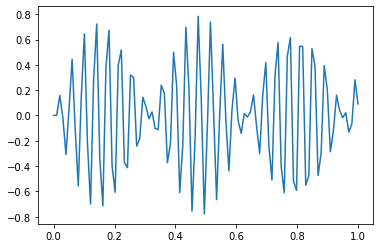

In [94]:
seq_len = 100
vals, _ = make_time_series(len=seq_len,freq1 = 150,freq2 = 170, phase1 = 0, phase2 = np.pi,noise_strength = 0)

plt.figure()
plt.plot(np.linspace(0,1,seq_len),vals)
plt.show()

In [103]:
num_examples = 5000
seq_len = 100

x_set,y_set = make_dataset(num_examples = num_examples,seq_len = seq_len,noise_strength = 0.1, freq1 = 150, freq2 = 170)

# leave the last 100 examples for validation set and put the rest in training set
x_train = x_set[:-1000,:,:]
y_train = y_set[:-1000,:,:]
x_valid = x_set[-1000:,:,:]
y_valid = y_set[-1000:,:,:]

print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(4000, 100, 1)
(1000, 100, 1)
(4000, 100, 1)
(1000, 100, 1)


We can implement this sequence-to-sequence mapping through a following model. 

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(2,input_shape=[None,1],return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation = "tanh"))
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
history = model.fit(x_train, y_train, epochs=20,
                    validation_data=(x_valid, y_valid))

Epoch 1/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0761 - val_loss: 0.0118
Epoch 2/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0111 - val_loss: 0.0107
Epoch 3/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0102 - val_loss: 0.0095
Epoch 4/20
125/125 [==============================] - 6s 44ms/step - loss: 0.0088 - val_loss: 0.0082
Epoch 5/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 6/20
125/125 [==============================] - 5s 42ms/step - loss: 0.0078 - val_loss: 0.0076
Epoch 7/20
125/125 [==============================] - 5s 43ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/20
125/125 [==============================] - 7s 54ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 9/20
125/125 [==============================] - 6s 45ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/20
125/125 [==============================] - 5s 44ms/step - loss: 0.0073 - val_lo

Let's see what the reconstruction of a sequence looks like.

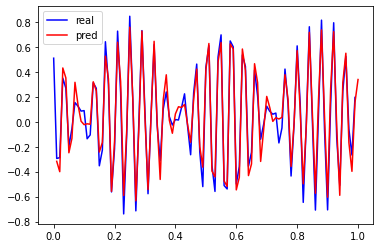

In [109]:
res = model.predict(x_train[-1:,:,:])[0]

plt.figure()
plt.plot(np.linspace(0,1-1/seq_len,seq_len),x_train[-1,:,:].reshape(-1),color = 'b',label='real')
plt.plot(np.linspace(1/seq_len,1,seq_len),res.reshape(-1), color = 'r',label='pred')
plt.legend()
plt.show()

Now, let us try to use this model to predict the future.

# Stacking Recursive Layers Together

Now, let's try stacking a couple of RNN layers together.

In [115]:
model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(5, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(10, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

model.summary()

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_valid, y_valid))

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_34 (SimpleRNN)    (None, None, 5)           35        
_________________________________________________________________
simple_rnn_35 (SimpleRNN)    (None, None, 10)          160       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1)           11        
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
125/125 [==============================] - 11s 86ms/step - loss: 0.0135 - val_loss: 0.0026
Epoch 2/10
125/125 [==============================] - 11s 85ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 3/10
125/125 [==============================] - 10s 84ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/10
125/125 [==============================] - 10s 83ms/step - loss: 0.0

Let's see what the predictions of our neural network look like.

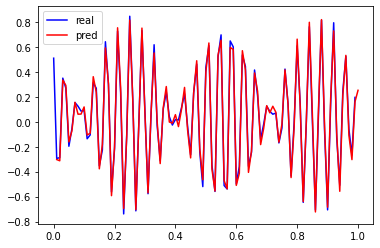

In [117]:
res = model.predict(x_train[-1:,:,:])[0]

plt.figure()
plt.plot(np.linspace(0,1-1/seq_len,seq_len),x_train[-1,:,:].reshape(-1),color = 'b',label='real')
plt.plot(np.linspace(1/seq_len,1,seq_len),res.reshape(-1), color = 'r',label='pred')
plt.legend()
plt.show()

Now, let's try to use this model to forecast the future.

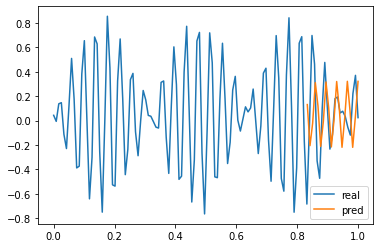

In [116]:
steps_ahead = 20
seq_len = 100

seq, _ = make_time_series(len = seq_len + steps_ahead,freq1 = 150, freq2 = 170, phase1 = 0, phase2 = np.pi, noise_strength = 0.1)
first_part = seq[:seq_len].reshape(-1,seq_len,1)

for i in range(steps_ahead):
  first_part = model.predict(first_part)

first_part = first_part.reshape(-1)

plt.figure()
plt.plot(np.linspace(0,1,seq_len+steps_ahead),seq, label = "real")
plt.plot(np.linspace(seq_len/(seq_len + steps_ahead),1,steps_ahead),first_part[-steps_ahead:], label="pred")
plt.legend()
plt.show()

# LSTM

When used to processs long sequences, RNNs tend to run into problems due to their high depth. One well known problem has to do with vanishing/exploding gradients: in a very deep neural network, the gradients with respect to distant inputs/weights tend to vanish, or in some circumstances blow up. While RNNs can in principle retain the memory of any input within their window, vanishing gradients lead to such memory being very short. The LSTM (Long Short Term Memory) module was designed to address this problem.

We will introduce LSTMs with a help of some illustrations from [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs). The linked blog post is a great place to learn more about this module.

Let us first represent the familiar basic RNNs using a slightly different graphical notation.

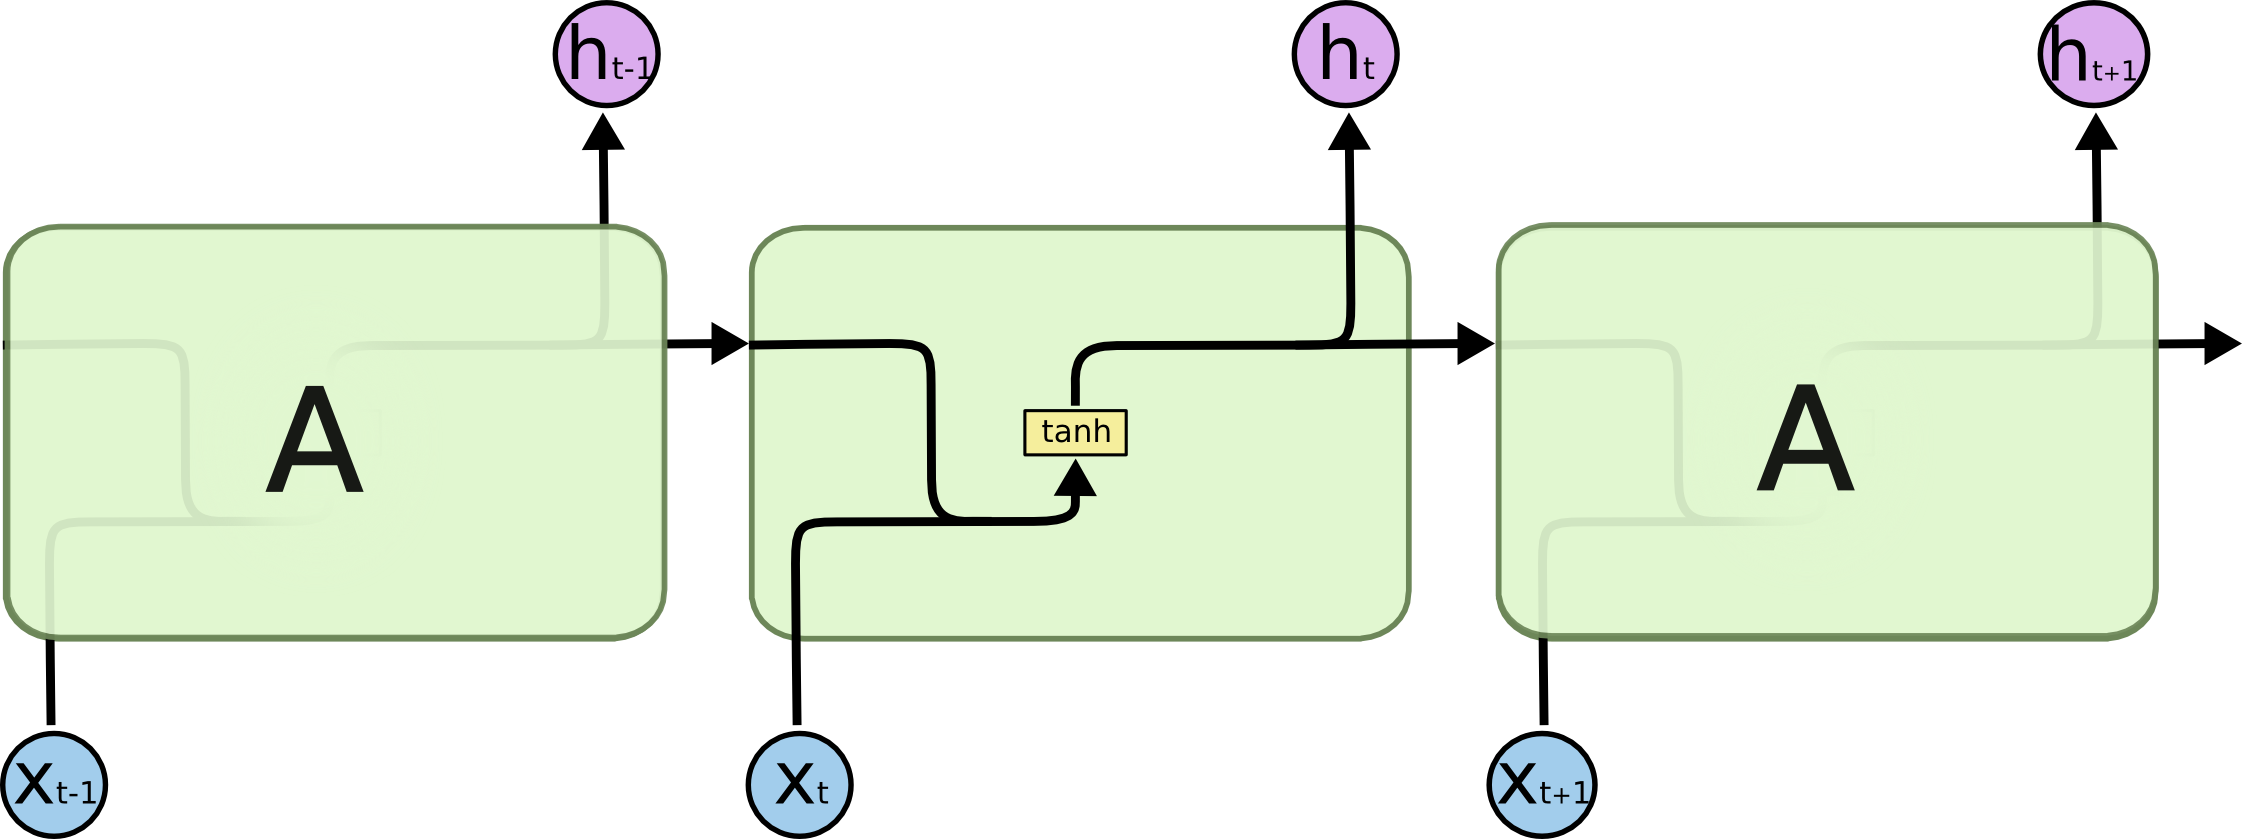

With help from this notation, the LSTM module can be represented as

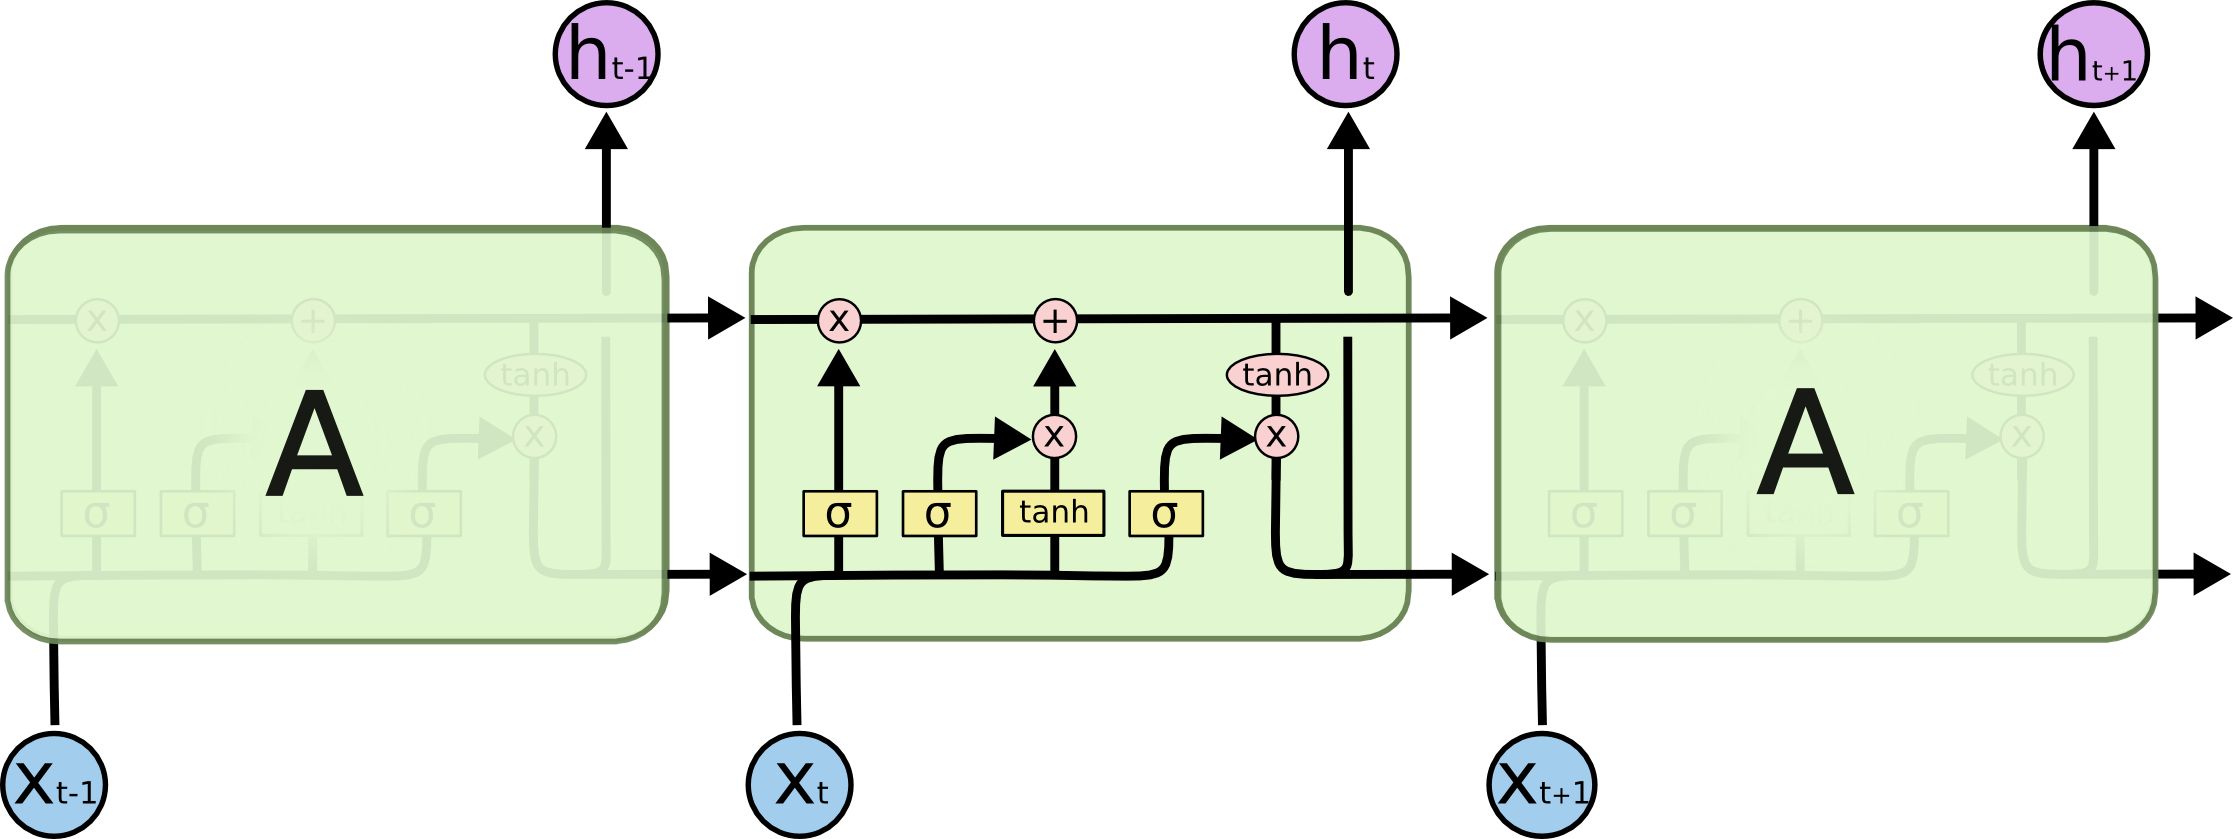

As we can see, the LSTM has two hidden states, rather than one. The "highway" on the upper side of the module allows for information from the inputs to be transported greater distances across the network.

Let's try to use a simple LSTM - based network for our problem.

In [118]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(5, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.LSTM(10, return_sequences=True),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))
])

model.summary()

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=0.01))
history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_valid, y_valid))

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 5)           140       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 10)          640       
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 1)           11        
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
125/125 [==============================] - 2s 14ms/step - loss: 0.0369 - val_loss: 0.0090
Epoch 2/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 3/10
125/125 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 4/10
125/125 [==============================] - 1s 10ms/step - loss: 0.0036 -

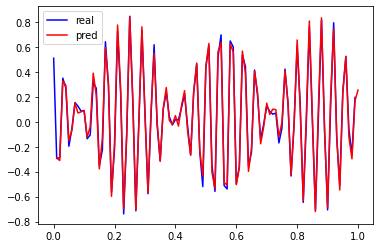

In [119]:
res = model.predict(x_train[-1:,:,:])[0]

plt.figure()
plt.plot(np.linspace(0,1-1/seq_len,seq_len),x_train[-1,:,:].reshape(-1),color = 'b',label='real')
plt.plot(np.linspace(1/seq_len,1,seq_len),res.reshape(-1), color = 'r',label='pred')
plt.legend()
plt.show()

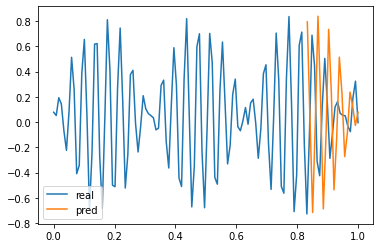

In [123]:
steps_ahead = 20
seq_len = 100

seq, _ = make_time_series(len = seq_len + steps_ahead,freq1 = 150, freq2 = 170, phase1 = 0, phase2 = np.pi, noise_strength = 0.1)
first_part = seq[:seq_len].reshape(-1,seq_len,1)

for i in range(steps_ahead):
  first_part = model.predict(first_part)

first_part = first_part.reshape(-1)

plt.figure()
plt.plot(np.linspace(0,1,seq_len+steps_ahead),seq, label = "real")
plt.plot(np.linspace(seq_len/(seq_len + steps_ahead),1,steps_ahead),first_part[-steps_ahead:], label="pred")
plt.legend()
plt.show()